In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### 1. Load train, test and validation data

In [2]:
with open('../../data/processed/autoencoder_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = np.array(data['X_train'])
X_test = np.array(data['X_test'])
X_val = np.array(data['X_val'])

In [3]:
y_test = set(data['y_test'])
y_train = set(data['y_train'])
y_val = set(data['y_val'])

#### 2. Define the autoencoder model

In [4]:
from keras.optimizers import Adam
from keras.models import Model, clone_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, BatchNormalization, Dense, LeakyReLU, ReLU

2024-07-12 18:29:00.883585: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 18:29:00.910715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 18:29:04.362287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
activation = LeakyReLU() # LeakyReLU()
input_signal = Input(shape=(600,))

layer_1 = Dense(256)(input_signal)
layer_1 = BatchNormalization()(layer_1)
layer_1 = activation(layer_1)

layer_2 = Dense(128)(layer_1)
layer_2 = BatchNormalization()(layer_2)
layer_2 = activation(layer_2)

layer_3 = Dense(32)(layer_2)
layer_3 = BatchNormalization()(layer_3)
layer_3 = activation(layer_3)

2024-07-12 18:29:19.368714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-12 18:29:19.406505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-12 18:29:19.410745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
encoder = Model(input_signal, layer_3, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    153,856 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      4,128 │ leaky_re_lu[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 192,544 (752.12 KB)

 Trainable params: 191,712 (748.88 KB)

 Non-trainable params: 832 (3.25 KB)

In [7]:
latent_sample = Input(shape=(32,))

layer_1 = Dense(128)(latent_sample)
layer_1 = BatchNormalization()(layer_1)
layer_1 = activation(layer_1)

layer_2 = Dense(256)(layer_1)
layer_2 = BatchNormalization()(layer_2)
layer_2 = activation(layer_2)

layer_3 = Dense(600)(layer_2)
layer_3 = BatchNormalization()(layer_3)
layer_3 = activation(layer_3)

In [8]:
decoder = Model(latent_sample, layer_3, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      4,224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 600)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     33,024 │ leaky_re_lu[3][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 600)       │    154,200 │ leaky_re_lu[4][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 600)       │      2,400 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,384 (763.22 KB)

 Trainable params: 193,416 (755.53 KB)

 Non-trainable params: 1,968 (7.69 KB)

In [9]:
autoencoder = Model(input_signal, decoder(encoder(input_signal)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       192,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 600)            │       195,384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,928 (1.48 MB)

 Trainable params: 385,128 (1.47 MB)

 Non-trainable params: 2,800 (10.94 KB)

#### 3. Hyperparameter optimisation

In [6]:
epochs = 100
batch_sizes = [32, 64, 128, 256]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

##### 3.1. Learning rate

In [7]:
history_arr = []
batch_size = 32
for learning_rate in learning_rates:
    history_dict = {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'history': []
    }
    for _ in range(5):
        tmp_model = clone_model(autoencoder)
        tmp_model.compile(
            optimizer=Adam(learning_rate=learning_rate), 
            loss='mean_squared_error'
        )
        history = tmp_model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            validation_data=(X_val, X_val)
        )
        history_dict['history'].append(history.history)
    history_arr.append(history_dict)

Epoch 1/100


I0000 00:00:1719422562.285331  331082 service.cc:145] XLA service 0x7fd124005660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719422562.285355  331082 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-06-26 18:22:42.303018: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-26 18:22:42.385728: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 215/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 0.1230

I0000 00:00:1719422562.760512  331082 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1816/1816 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0699 - val_loss: 0.0191
Epoch 2/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 823us/step - loss: 0.0102 - val_loss: 0.0064
Epoch 3/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step - loss: 0.0050 - val_loss: 0.0054
Epoch 4/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 5/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 823us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 6/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - loss: 0.0032 - val_loss: 0.0037
Epoch 7/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - loss: 0.0030 - val_loss: 0.0036
Epoch 8/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step - loss: 0.0028 - val_loss: 0.0034
Epoch 9/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 828us/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 2s 829us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 11/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 12/10

In [8]:
import json
with open('experiments/autoencoder_history_lr.json', 'w') as f:
    json.dump(history_arr, f)

##### 3.2. Mini-batch size

In [9]:
history_arr = []
learning_rate = 1e-4
for batch_size in batch_sizes:
    history_dict = {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'history': []
    }
    for _ in range(5):
        tmp_model = clone_model(autoencoder)
        tmp_model.compile(
            optimizer=Adam(learning_rate=learning_rate), 
            loss='mean_squared_error'
        )
        history = tmp_model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            validation_data=(X_val, X_val)
        )
        history_dict['history'].append(history.history)
    history_arr.append(history_dict)

Epoch 1/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 3s 990us/step - loss: 0.0275 - val_loss: 0.0049
Epoch 2/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 0.0034 - val_loss: 0.0026
Epoch 3/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 9.9634e-04 - val_loss: 0.0011
Epoch 9/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 0.0010 - val_loss: 9.9098e-04
Epoch 10/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.0010 - val_loss: 9.6702e-04
Epoch 11/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 9.1447e-04 

In [10]:
with open('experiments/autoencoder_history_batch.json', 'w') as f:
    json.dump(history_arr, f)

#### 4. Visualise training history results

In [35]:
with open('experiments/autoencoder_history_lr.json', 'r') as f:
    history_arr = json.load(f)

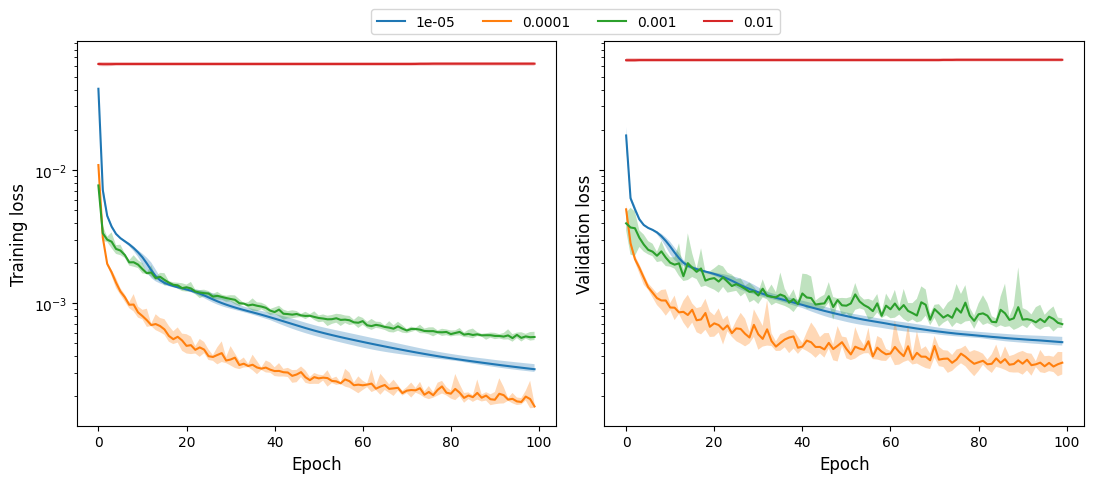

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharey=True)
for history_dict in history_arr:
    label = f'{history_dict["learning_rate"]}'
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    max_train_loss = np.max([history['loss'] for history in history_dict['history']], axis=0)
    max_val_loss = np.max([history['val_loss'] for history in history_dict['history']], axis=0)
    min_train_loss = np.min([history['loss'] for history in history_dict['history']], axis=0)
    min_val_loss = np.min([history['val_loss'] for history in history_dict['history']], axis=0)
    ax[0].plot(mean_train_loss, label=label)
    ax[0].fill_between(range(len(mean_train_loss)), min_train_loss, max_train_loss, alpha=0.3)
    ax[1].plot(mean_val_loss, label=label)
    ax[1].fill_between(range(len(mean_val_loss)), min_val_loss, max_val_loss, alpha=0.3)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Training loss', fontsize=12)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Validation loss', fontsize=12)
ax[0].semilogy()
ax[1].semilogy()
ax[0].legend(bbox_to_anchor=(0.6, 1.1), ncols=4, loc='upper left')
fig.subplots_adjust(wspace=0.1)
plt.savefig('figures/autoencoder_lr_history.pdf', bbox_inches='tight')
plt.show()

In [36]:
# Print the difference between the training and validation loss
for history_dict in history_arr:
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    print(f'Learning rate: {history_dict["learning_rate"]}, Difference: {mean_train_loss[-1] - mean_val_loss[-1]}')

Learning rate: 1e-05, Difference: -0.0001906148158013821
Learning rate: 0.0001, Difference: -0.00018997378356289119
Learning rate: 0.001, Difference: -0.0001388252247124911
Learning rate: 0.01, Difference: -0.00435895100235939


In [30]:
with open('experiments/autoencoder_history_batch.json', 'r') as f:
    history_arr = json.load(f)

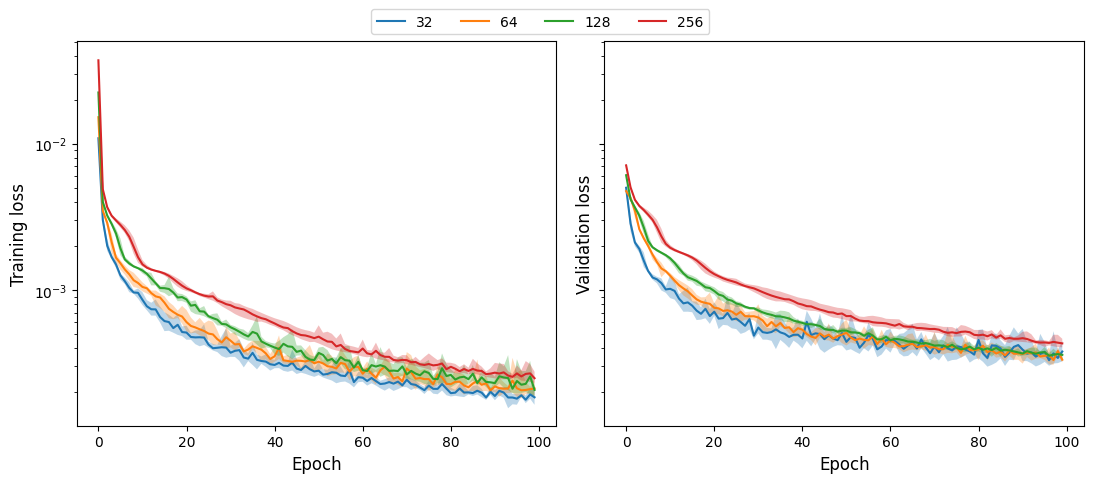

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharey=True)
for history_dict in history_arr:
    label = f'{history_dict["batch_size"]}'
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    max_train_loss = np.max([history['loss'] for history in history_dict['history']], axis=0)
    max_val_loss = np.max([history['val_loss'] for history in history_dict['history']], axis=0)
    min_train_loss = np.min([history['loss'] for history in history_dict['history']], axis=0)
    min_val_loss = np.min([history['val_loss'] for history in history_dict['history']], axis=0)
    ax[0].plot(mean_train_loss, label=label)
    ax[0].fill_between(range(len(mean_train_loss)), min_train_loss, max_train_loss, alpha=0.3)
    ax[1].plot(mean_val_loss, label=label)
    ax[1].fill_between(range(len(mean_val_loss)), min_val_loss, max_val_loss, alpha=0.3)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Training loss', fontsize=12)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Validation loss', fontsize=12)
ax[0].semilogy()
ax[1].semilogy()
ax[0].legend(bbox_to_anchor=(0.6, 1.1), ncols=4, loc='upper left')
fig.subplots_adjust(wspace=0.1)
plt.savefig('figures/autoencoder_batch_history.pdf', bbox_inches='tight')
plt.show()

In [33]:
# Print the difference between mean training and validation loss
for history_dict in history_arr:
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    print(f'Batch size: {history_dict["batch_size"]}, Difference: {mean_train_loss[-1] - mean_val_loss[-1]}')

Batch size: 32, Difference: -0.00019470938423182815
Batch size: 64, Difference: -0.00012138470192439856
Batch size: 128, Difference: -0.00015270377625711264
Batch size: 256, Difference: -0.00018185242370236663


#### 5. Train and save a model with optimal hyperparameters

In [10]:
optimizer = Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [11]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=500,
    batch_size=64,
    shuffle=False,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
)

Epoch 1/500


I0000 00:00:1720805376.310914   35220 service.cc:145] XLA service 0x7fb6e4027d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720805376.310935   35220 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-07-12 18:29:36.349148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-12 18:29:36.513667: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


152/908 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.4525

I0000 00:00:1720805377.137602   35220 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2983 - val_loss: 1.0183
Epoch 2/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1358 - val_loss: 0.9363
Epoch 3/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1142 - val_loss: 0.7910
Epoch 4/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0970 - val_loss: 0.8273
Epoch 5/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0819 - val_loss: 0.5491
Epoch 6/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0687 - val_loss: 0.4668
Epoch 7/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0563 - val_loss: 0.4772
Epoch 8/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0458 - val_loss: 0.3088
Epoch 9/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0373 - val_loss: 0.3451
Epoch 10/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0300 - val_loss: 0.3192
Epoch 11/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0243 - val_loss: 0.1384
Epoch 12/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [12]:
# autoencoder.save('../../models/dense/ReLU_BatchNorm_ThreeLayers_32.keras')
autoencoder.save('../../models/dense/LeakyReLU_BatchNorm_Three_Layers_32.keras')

#### 6. Evaluate model on test data 

In [4]:
from tensorflow.keras.models import load_model
autoencoder = load_model('../../models/dense/ReLU_BatchNorm_ThreeLayers_32.keras') # load_model('../../models/dense/LeakyReLU_BatchNorm_Three_Layers_32.keras')

2024-07-02 13:20:00.465317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 13:20:00.492841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 13:20:04.027899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-02 13:20:10.816594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

In [13]:
test_loss = autoencoder.evaluate(X_test, X_test)
print(f'Test loss: {test_loss}')

607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - loss: 0.0076
Test loss: 0.006451043765991926


In [14]:
y_pred = autoencoder.predict(X_test)
y_pred.shape

607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step


(19400, 600)

In [15]:
# Calculate the reconstruction error
reconstruction_error = np.mean(np.abs(y_pred - X_test), axis=1)
reconstruction_error.shape

(19400,)

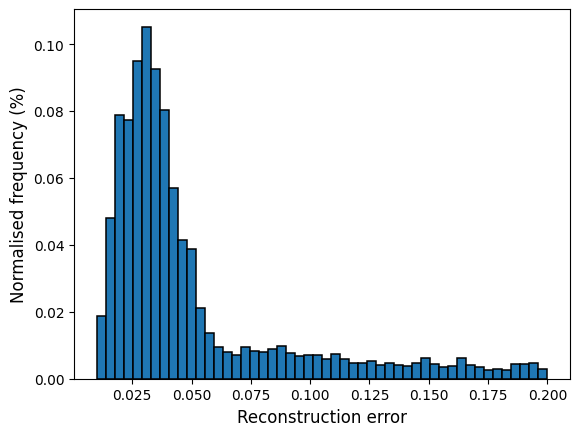

In [16]:
weights = np.ones_like(reconstruction_error) / float(len(reconstruction_error))

fig, ax = plt.subplots()
ax.hist(reconstruction_error, bins=50, range=(0.01, 0.2), weights=weights, edgecolor='black', linewidth=1.1)
ax.set_xlabel('Reconstruction error', fontsize=12)
ax.set_ylabel('Normalised frequency (%)', fontsize=12)
# plt.savefig('figures/autoencoder_reconstruction_error_relu.pdf', bbox_inches='tight')
plt.show()

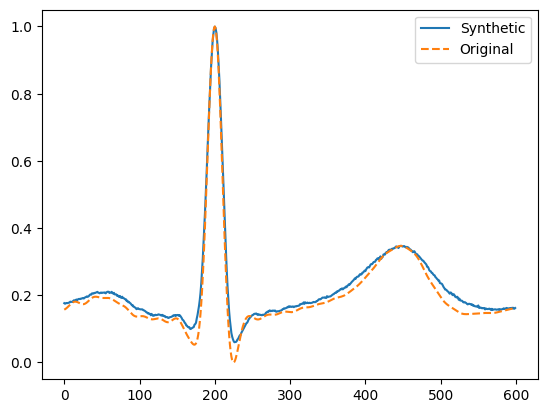

In [18]:
fig, ax = plt.subplots()
ax.plot(y_pred[-1], label='Synthetic')
ax.plot(X_test[-1], '--', label='Original')
ax.legend()
plt.show()